# Tesla Stock Prediction with LSTMs

## Imports several libraries and tools for data processing and machine learning

- **NumPy** for numerical operations.
- **Pandas** for data manipulation (e.g., working with CSV files).
- **Matplotlib** and **Seaborn** for data visualization.
- **Scikit-learn** tools for scaling data (MinMaxScaler, StandardScaler), applying custom transformations (FunctionTransformer), and splitting data into training and testing sets (train_test_split). 

In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [90]:
df = pd.read_csv('HistoricalData_tesla.csv')
df.head()

Date Close/Last     Volume     Open     High      Low
0  02/18/2025    $354.11   51631700  $355.01  $359.10  $350.02
1  02/14/2025    $355.84   68277280  $360.62  $362.00  $347.50
2  02/13/2025    $355.94   89441520  $345.00  $358.69  $342.85
3  02/12/2025    $336.51  105382700  $329.94  $346.40  $329.12
4  02/11/2025    $328.50  118543400  $345.80  $349.37  $325.10

In [91]:
df['Date'] = pd.to_datetime(df['Date'])

In [92]:
# Sort by date in ascending order
df = df.sort_values(by='Date')

In [93]:
df

Date Close/Last     Volume      Open      High       Low
2514 2015-02-19   $14.1137   77058006  $13.6667  $14.1627  $13.5833
2513 2015-02-20    $14.474   89675595   $14.052  $14.5067  $13.9873
2512 2015-02-23   $13.8223  127306901  $14.3773  $14.5467  $13.7553
2511 2015-02-24   $13.6073   98809421  $13.8193  $13.8193  $13.4467
2510 2015-02-25    $13.584   58612546  $13.6627  $13.8093  $13.5053
...         ...        ...        ...       ...       ...       ...
4    2025-02-11    $328.50  118543400   $345.80   $349.37   $325.10
3    2025-02-12    $336.51  105382700   $329.94   $346.40   $329.12
2    2025-02-13    $355.94   89441520   $345.00   $358.69   $342.85
1    2025-02-14    $355.84   68277280   $360.62   $362.00   $347.50
0    2025-02-18    $354.11   51631700   $355.01   $359.10   $350.02

[2515 rows x 6 columns]

In [94]:
import pandas as pd

# Columns containing prices
price_columns = ['Close/Last', 'Open', 'High', 'Low']

# Remove the '$' sign and convert to float
for col in price_columns:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

In [95]:
# INFORMATION ABOUT DATASET
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2515 entries, 2514 to 0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2515 non-null   datetime64[ns]
 1   Close/Last  2515 non-null   float64       
 2   Volume      2515 non-null   int64         
 3   Open        2515 non-null   float64       
 4   High        2515 non-null   float64       
 5   Low         2515 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 137.5 KB


In [96]:
# CHOSE CLOSE PRICE FROM DATASET FOR PREDICTION
close_price = df[['Close/Last']]
close_price.head()

Close/Last
2514     14.1137
2513     14.4740
2512     13.8223
2511     13.6073
2510     13.5840

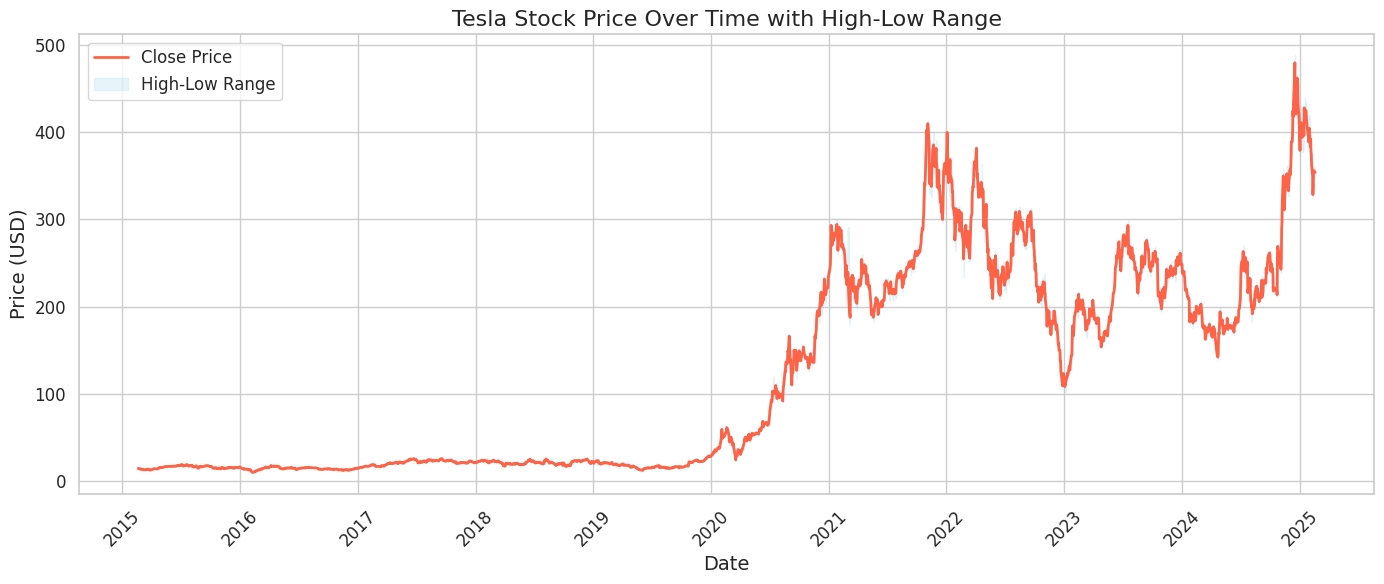

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting Seaborn style
sns.set(style="whitegrid")

# Creating the plot
plt.figure(figsize=(14, 6))

# Plotting the 'close' price
sns.lineplot(data=df, x='Date', y='Close/Last', label='Close Price', color='tomato', linewidth=2)

# Adding a shaded area for high and low
plt.fill_between(x=df['Date'], y1=df['High'], y2= df['Low'], color='skyblue', alpha=0.2, label='High-Low Range')

# Adding plot details
plt.title('Tesla Stock Price Over Time with High-Low Range', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Displaying the plot
plt.show()


In [98]:
def create_feature_target_dataframe(df, column, window_size=5):
    values = df[column].values
    
    # Initialize lists to store the feature rows and targets
    features = []
    targets = []
    columns = []

    # Loop through the values, taking 5 values as features and the 6th as the target
    for i in range(len(values) - window_size):
        feature_row = values[i:i+window_size]
        target = values[i+window_size]
        
        # Append the feature row and target to the respective lists
        features.append(feature_row)
        targets.append(target)

    for i in range(window_size):
        col = f"x{i+1}"
        columns.append(col)
        
    # Create a new DataFrame from the feature rows and targets
    new_df = pd.DataFrame(features, columns=columns)
    new_df['target'] = targets
    
    return new_df

In [99]:
tesla_df = create_feature_target_dataframe(
    df=df,
    column='Close/Last',
    window_size=7
)
tesla_df.tail(10)

x1      x2      x3      x4      x5      x6      x7  target
2498  406.58  397.15  398.09  389.10  400.28  404.60  383.68  392.21
2499  397.15  398.09  389.10  400.28  404.60  383.68  392.21  378.17
2500  398.09  389.10  400.28  404.60  383.68  392.21  378.17  374.32
2501  389.10  400.28  404.60  383.68  392.21  378.17  374.32  361.62
2502  400.28  404.60  383.68  392.21  378.17  374.32  361.62  350.73
2503  404.60  383.68  392.21  378.17  374.32  361.62  350.73  328.50
2504  383.68  392.21  378.17  374.32  361.62  350.73  328.50  336.51
2505  392.21  378.17  374.32  361.62  350.73  328.50  336.51  355.94
2506  378.17  374.32  361.62  350.73  328.50  336.51  355.94  355.84
2507  374.32  361.62  350.73  328.50  336.51  355.94  355.84  354.11

In [100]:
tesla_df.shape

(2508, 8)

In [101]:
x = tesla_df.drop('target',axis=1)
y = tesla_df['target']

# Splits the data into training and testing sets:

- **train_test_split(x, y, test_size=0.2)**: 
  - Splits the feature set `x` and target `y` into training (80%) and testing (20%) sets.
  
- **x_train, x_test, y_train, y_test**: 
  - Assigns the training and testing data for features (`x_train`, `x_test`) and target (`y_train`, `y_test`).

## Tesla Stocks Prediction using LSTMs

### Import Libraries for LSTMs
- **`numpy`**: For numerical operations and handling arrays.
- **`pandas`**: For data manipulation and analysis (e.g., DataFrames).
- **`tensorflow`**: A library for machine learning and deep learning.
- **`tensorflow.keras`**: High-level API for building neural networks in TensorFlow.
- **`sklearn.preprocessing.MinMaxScaler`**: Scales features to a specified range.
- **`sklearn.model_selection.train_test_split`**: Splits data into training and testing sets.

In [102]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Generate example time-series data (replace with your dataset)
x = np.array(x)

X = x.reshape(x.shape[0], x.shape[1], 1)  

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [103]:
X_train.shape,X_test.shape

((2006, 7, 1), (502, 7, 1))

# This code defines and builds an LSTM model for regression

- **`LSTM(100, activation='relu', return_sequences=True)`**: Adds an LSTM layer with 100 units and ReLU activation. The `return_sequences=True` argument ensures the output is fed to the next LSTM layer.
- **`Dropout(0.2)`**: Adds dropout with 20% rate to prevent overfitting.
- **`LSTM(100, activation='relu')`**: Adds another LSTM layer with 100 units.
- **`Dense(1, activation='linear')`**: Adds a dense layer with 1 output unit and a linear activation function for regression.
- **`model.compile(optimizer='adam', loss='mse')`**: Compiles the model with the Adam optimizer and mean squared error (MSE) loss function.


In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout,BatchNormalization

# Define the LSTM model with multiple layers
def build_lstm_model(input_shape):
    model = Sequential([
        (LSTM(120, activation='relu', return_sequences=True, input_shape=input_shape)),
        Dropout(0.3),
        BatchNormalization(),
        (LSTM(120, activation='relu')),
        Dense(1, activation='linear')  # Linear activation for regression tasks
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the model
input_shape = (X_train.shape[1], 1)
model = build_lstm_model(input_shape)

model.summary()

/home/junaid-ul-hassan/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 7, 120)         │        58,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 120)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 120)         │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 120)            │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,841 (682.97 KB)

 Trainable params: 174,601 (682.04 KB)

 Non-trainable params: 240 (960.00 B)

## Train LSTM model with **EarlyStopping**:

- **`EarlyStopping`**: Stops training if the validation loss doesn't improve for a specified number of epochs (`patience=100`). It restores the model weights from the best epoch.
- **`model.fit()`**: Trains the model with the **EarlyStopping** callback, using the training data (`X_train`, `y_train`) and validation data (`X_test`, `y_test`).
- **`model.evaluate()`**: Evaluates the model on both the training and testing data and prints the loss values.

The early stopping mechanism prevents overfitting by halting training early when the model's performance stops improving.

In [107]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=6,          # Stop training after 10 epochs with no improvement
    restore_best_weights=True,  # Restore the model weights from the best epoch
    mode='min',           # Mode 'min' means training will stop when the validation loss stops decreasing
    verbose=1
)

# Train the model with EarlyStopping callback
history = model.fit(
    X, y,
    epochs=20,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)

Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 620.4944 - val_loss: 425.1365
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 464.4364 - val_loss: 485.8609
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 654.1714 - val_loss: 486.2337
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 399.4946 - val_loss: 714.3138
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 526.1010 - val_loss: 728.5681
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 425.5787 - val_loss: 1050.9851
Epoch 7/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 399.6309 - val_loss: 295.9250
Epoch 8/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 316.5843 - val_loss: 1414.1663
Epoch 9/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 405.1970 - val_loss: 812.4941
Epoch 10/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 341.6768 - val_loss: 523.1577
Epoch 11/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 311.3814 - val_loss: 314.

# Code evaluates the model's performance and visualizes the results

- **`model.predict(X_test)`**: Makes predictions on the test set.
- **`r2_score(y_test, predictions)`**: Calculates the R² score, measuring how well the model's predictions match the actual values.
- **`plot_loss(history)`**: Visualizes:
  - The training and validation loss over epochs.
  - The R² score as a bar plot.
- **`plt.tight_layout()`**: Adjusts the layout for better visualization. 

The plots help in understanding the model's performance during training and its predictive accuracy.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R² Score: 0.9357


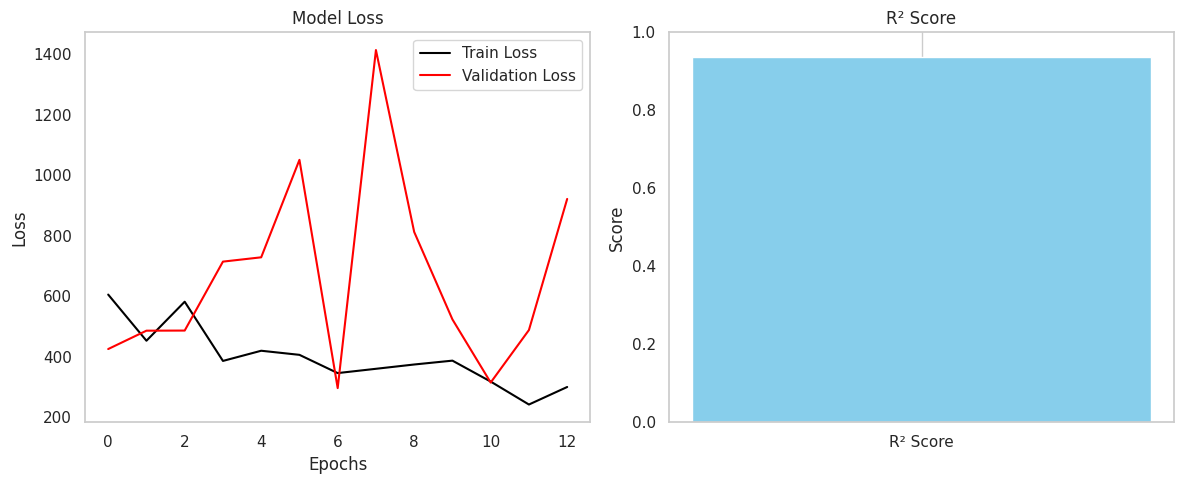

In [108]:
# Make predictions
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# Visualization of Loss and R²
def plot_loss(history):
    plt.figure(figsize=(12, 5))

    # Plot loss over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='black')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot R² score
    plt.subplot(1, 2, 2)
    plt.bar(['R² Score'], [r2], color='skyblue')
    plt.ylim(0, 1)
    plt.title('R² Score')
    plt.ylabel('Score')
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_loss(history)


## Calculates and visualizes the model's performance metrics

- **Metrics**:
  - **MSE (Mean Squared Error)**: Measures the average squared difference between actual and predicted values.
  - **RMSE (Root Mean Squared Error)**: The square root of MSE, representing error in the same unit as the target.
  - **R² Score**: Measures the proportion of variance explained by the model.

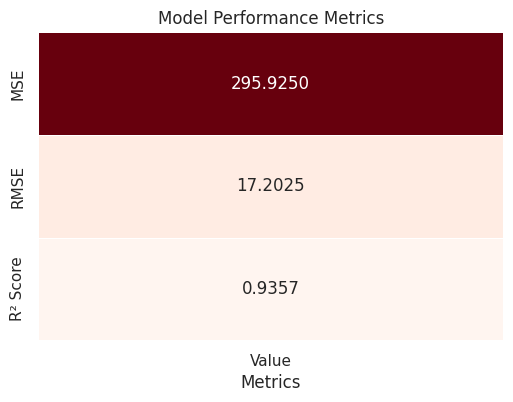

In [109]:
import seaborn as sns

# Calculate metrics
mse = np.mean((y_test - predictions.flatten()) ** 2)
rmse = np.sqrt(mse)

# Create a dictionary for the metrics
metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'R² Score': r2
}

# Visualization: Heatmap of Metrics
def plot_metrics_heatmap(metrics):
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        pd.DataFrame(metrics, index=["Value"]).T,
        annot=True, fmt=".4f", cmap="Reds",
        cbar=False, linewidths=0.5
    )
    plt.title("Model Performance Metrics")
    plt.xlabel("Metrics")
    plt.ylabel("")
    plt.show()

# Call the heatmap plotting function
plot_metrics_heatmap(metrics)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


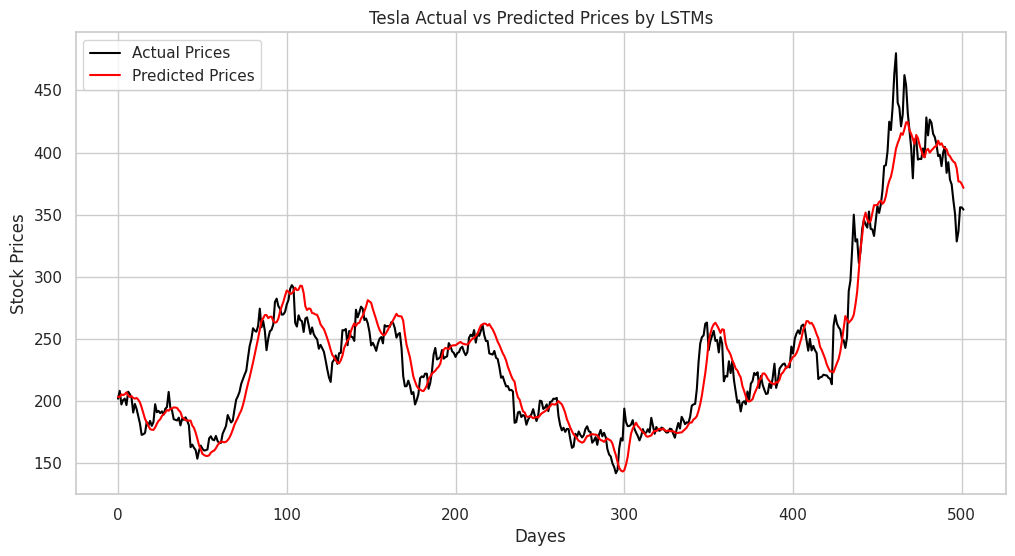

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Predict using the model
y_pred = model.predict(X_test)

# Ensure both actual and predicted are reshaped properly for plotting
y_test_flat = np.ravel(y_test)  # Flatten y_test
y_pred_flat = np.ravel(y_pred)  # Flatten y_pred

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='Actual Prices',color='black')
plt.plot(y_pred_flat, label='Predicted Prices',color='red')
plt.title("Tesla Actual vs Predicted Prices by LSTMs")
plt.xlabel("Dayes")
plt.ylabel("Stock Prices")
plt.legend()
plt.grid(True)
plt.show()


In [111]:
X_train.shape

(2006, 7, 1)

In [112]:
model.save('Tesla_model.h5')

In [113]:
import tensorflow as tf

# Load the model with the correct loss function
model = tf.keras.models.load_model("Tesla_model.h5", compile=False)  # Load without compilation
model.compile(loss=tf.keras.losses.MeanSquaredError())  # Recompile with the correct loss function

# Print model summary
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 7, 120)         │        58,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 120)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 120)         │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 120)            │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,841 (682.97 KB)

 Trainable params: 174,601 (682.04 KB)

 Non-trainable params: 240 (960.00 B)

In [123]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch Tesla stock data
tesla = yf.Ticker("TSLA")
stock_values = tesla.history(period="1d")["Close"]
stock_values

Date
2025-02-19 00:00:00-05:00    360.559998
Name: Close, dtype: float64

In [115]:
stock_values.index

DatetimeIndex(['2025-01-22 00:00:00-05:00', '2025-01-23 00:00:00-05:00',
               '2025-01-24 00:00:00-05:00', '2025-01-27 00:00:00-05:00',
               '2025-01-28 00:00:00-05:00', '2025-01-29 00:00:00-05:00',
               '2025-01-30 00:00:00-05:00', '2025-01-31 00:00:00-05:00',
               '2025-02-03 00:00:00-05:00', '2025-02-04 00:00:00-05:00',
               '2025-02-05 00:00:00-05:00', '2025-02-06 00:00:00-05:00',
               '2025-02-07 00:00:00-05:00', '2025-02-10 00:00:00-05:00',
               '2025-02-11 00:00:00-05:00', '2025-02-12 00:00:00-05:00',
               '2025-02-13 00:00:00-05:00', '2025-02-14 00:00:00-05:00',
               '2025-02-18 00:00:00-05:00', '2025-02-19 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', freq=None)

### Code Explaination

This code **forecasts the next 7 stock prices** using a trained model:  

- **Converts** `stock_values` into a list to allow appending new predictions.  
- **Iterates 7 times** to predict future values.  
- **Prepares input data** by taking the last **7 values** and reshaping it into the required format for the model.  
- **Uses `model.predict(values)`** to generate a forecast.  
- **Extracts the predicted price** (`next_value`) and appends it to `current_price`.  

The purpose is to **extend stock price predictions for the next 7 days** using a machine learning model.

In [116]:
current_price = list(stock_values)  # Ensure it's a list for appending
# Forecast next 7 values
for i in range(7):
    values = np.array(current_price[-7:]).reshape(1, 7, 1)  # Take last 4 value
    prediction = model.predict(values)
    next_value = prediction[0][0]  # Extract scalar prediction
    current_price.append(next_value)  # Append predicted value

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [117]:
current_price

[415.1099853515625,
 412.3800048828125,
 406.5799865722656,
 397.1499938964844,
 398.0899963378906,
 389.1000061035156,
 400.2799987792969,
 404.6000061035156,
 383.67999267578125,
 392.2099914550781,
 378.1700134277344,
 374.32000732421875,
 361.6199951171875,
 350.7300109863281,
 328.5,
 336.510009765625,
 355.94000244140625,
 355.8399963378906,
 354.1099853515625,
 360.55999755859375,
 360.39026,
 358.60867,
 365.01633,
 371.50043,
 372.55508,
 373.95325,
 376.31818]

<Axes: >

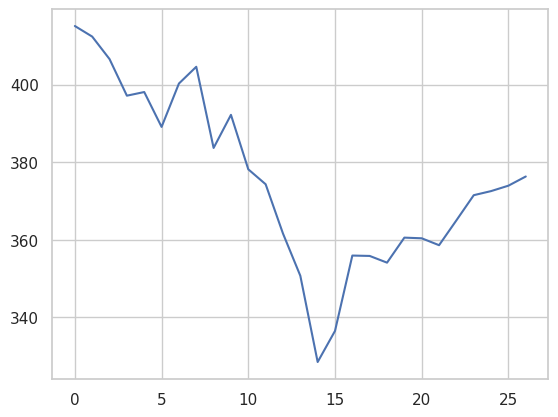

In [118]:
sns.lineplot(current_price)

In [119]:
import pandas as pd
dates = stock_values.index

# Calculate the difference (gap) between the last two dates
gap = dates[-1] - dates[-2]  

# Generate the next 4 dates by adding the gap
next_dates = [dates[-1] + gap * (i + 1) for i in range(7)]

# Convert to DatetimeIndex
next_dates = pd.DatetimeIndex(next_dates)

# Combine with existing dates
all_dates = dates.append(next_dates)

print("All dates:", all_dates)



All dates: DatetimeIndex(['2025-01-22 00:00:00-05:00', '2025-01-23 00:00:00-05:00',
               '2025-01-24 00:00:00-05:00', '2025-01-27 00:00:00-05:00',
               '2025-01-28 00:00:00-05:00', '2025-01-29 00:00:00-05:00',
               '2025-01-30 00:00:00-05:00', '2025-01-31 00:00:00-05:00',
               '2025-02-03 00:00:00-05:00', '2025-02-04 00:00:00-05:00',
               '2025-02-05 00:00:00-05:00', '2025-02-06 00:00:00-05:00',
               '2025-02-07 00:00:00-05:00', '2025-02-10 00:00:00-05:00',
               '2025-02-11 00:00:00-05:00', '2025-02-12 00:00:00-05:00',
               '2025-02-13 00:00:00-05:00', '2025-02-14 00:00:00-05:00',
               '2025-02-18 00:00:00-05:00', '2025-02-19 00:00:00-05:00',
               '2025-02-20 00:00:00-05:00', '2025-02-21 00:00:00-05:00',
               '2025-02-22 00:00:00-05:00', '2025-02-23 00:00:00-05:00',
               '2025-02-24 00:00:00-05:00', '2025-02-25 00:00:00-05:00',
               '2025-02-26 00:00:00-05:0

In [120]:
 len(all_dates)

27

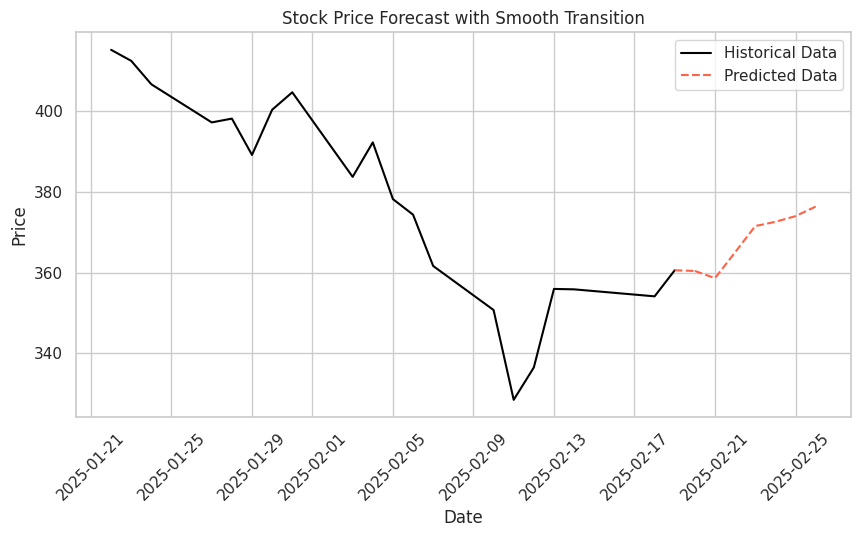

In [121]:
# Split real and predicted values
real_dates = all_dates[:-7]
predicted_dates = all_dates[-7:]

real_prices = current_price[:-7]
predicted_prices = current_price[-7:]

# Plot historical data
plt.figure(figsize=(10, 5))
sns.lineplot(x=real_dates, y=real_prices, label="Historical Data", color="black")

# **Connect last real point to first predicted point**
transition_dates = [real_dates[-1], predicted_dates[0]]
transition_prices = [real_prices[-1], predicted_prices[0]]
plt.plot(transition_dates, transition_prices, color="tomato", linestyle="dashed")  # Transition Line

# Plot predicted data in a different color
sns.lineplot(x=predicted_dates, y=predicted_prices, label="Predicted Data", color="tomato", linestyle="dashed")

# Labels & title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Price Forecast with Smooth Transition")
plt.xticks(rotation=45)
plt.legend()
plt.show()


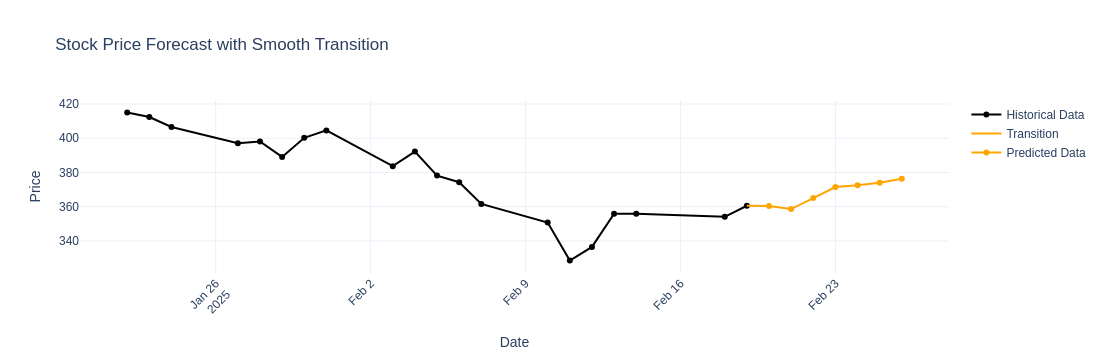

In [122]:
import pandas as pd
import plotly.graph_objects as go


# Split real and predicted values
real_dates = all_dates[:-7]
predicted_dates = all_dates[-7:]

real_prices = current_price[:-7]
predicted_prices = current_price[-7:]

# Create the Plotly figure
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(
    x=real_dates, y=real_prices,
    mode='lines+markers',
    name='Historical Data',
    line=dict(color='black', width=2)
))

# Add transition segment to connect last real point to first predicted point
fig.add_trace(go.Scatter(
    x=[real_dates[-1], predicted_dates[0]],
    y=[real_prices[-1], predicted_prices[0]],
    mode='lines',
    name='Transition',
    line=dict(color='orange', width=2)
))

# Add predicted data
fig.add_trace(go.Scatter(
    x=predicted_dates, y=predicted_prices,
    mode='lines+markers',
    name='Predicted Data',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title="Stock Price Forecast with Smooth Transition",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis=dict(tickangle=-45),
    template="plotly_white",
    height=700  # Increase height (default is 450)

)

# Show the interactive plot
fig.show()
